In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
Dataset_dir = ["./train.csv", "./store.csv","./test.csv"]
pd.options.display.max_columns = None

In [3]:
def load_data(dir):
    data = pd.read_csv(dir[0],parse_dates=[2])
    store = pd.read_csv(dir[1])
    test = pd.read_csv(dir[2],parse_dates=[3])
    return data,store,test

In [4]:
train,store,test = load_data(Dataset_dir)
train = train[train['Open'] != 0]
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
print(train.columns)
print(test.columns)

D:\AnaconDA\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [5]:
#对时间序列进行分析
#总的销售趋势2013-2015年
# train['date'] = pd.to_datetime(train.Date)
# data = train.loc[:,['Sales']]
# data = data.set_index(train.date)
# data.plot()

# weekly = data.resample('W').sum()
# weekly.plot()

# dayily = data.resample('D').sum()
# dayily.plot()

In [6]:
TESTID = test['Id']

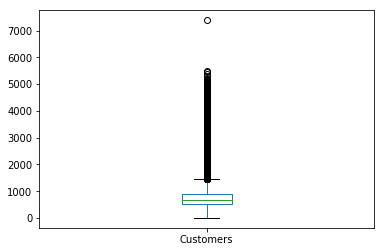

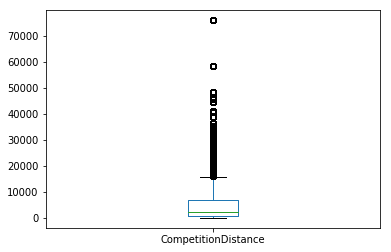

In [7]:
train.Customers.plot(kind='box')
plt.show()
train.CompetitionDistance.plot(kind='box')
plt.show()

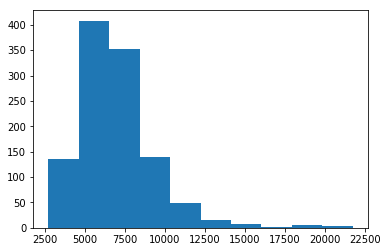

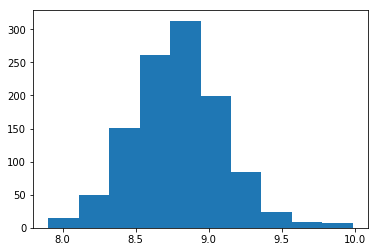

In [8]:
sales_mean = train.groupby('Store')['Sales'].mean()
plt.hist(sales_mean)
plt.show()
plt.hist(np.log1p(sales_mean))
plt.show()

In [9]:
Store_DaysWeek = train.groupby(['Store','DayOfWeek'])
sw_mean = Store_DaysWeek["Sales"].mean()

In [10]:
def build_feature(data,istrain):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #CART回归树不需要预处理数据和NAn值
#     distance_max = max(data.CompetitionDistance)
#     data.CompetitionDistance.mask(data.CompetitionDistance.isna(),other=distance_max,inplace=True)
#     print(data.CompetitionDistance.isnull().any())
#     min_max_scaler = MinMaxScaler()
#     scaledata = min_max_scaler.fit_transform(data[['CompetitionDistance']])
#     data.drop("CompetitionDistance",axis=1)
#     data['CompetitionDistance'] = scaledata
    #时间序列问题 需要考虑进时间的因素
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    
    if istrain:
        #data.drop(['Store','Open','Date','Customers','PromoInterval',],axis=1,inplace=True)
        data.drop(['Store','Open','Date','Customers','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    else:
        #data.drop(['Id','Store','Open','Date','PromoInterval',],axis=1,inplace=True)
        data.drop(['Id','Store','Open','Date','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    print(data.columns)

In [11]:
#build train data
build_feature(train,True)
#build test data
build_feature(test,False)

Index(['DayOfWeek', 'Sales', 'Promo', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')
Index(['DayOfWeek', 'Promo', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
       'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')


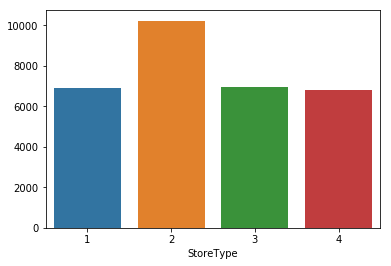

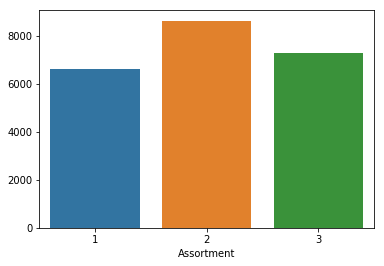

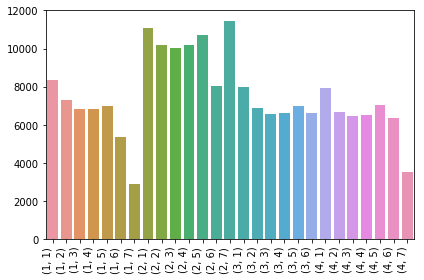

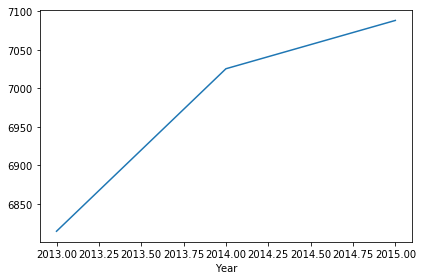

In [12]:
ST_gp = train.groupby('StoreType')['Sales'].agg('mean')
import seaborn as sns
sns.barplot(ST_gp.index,ST_gp.values)
plt.show()

As_gp = train.groupby('Assortment')['Sales'].agg('mean')
sns.barplot(As_gp.index,As_gp.values)
plt.show()
Dayweek_gp = train.groupby(['StoreType','DayOfWeek'])['Sales'].agg('mean')
ax = sns.barplot(Dayweek_gp.index,Dayweek_gp.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

#每年销售额的趋势
YearS_gp = train.groupby(['Year'])['Sales'].agg("mean")
ax2 = sns.lineplot(YearS_gp.index,YearS_gp.values)
plt.tight_layout()
plt.show()

In [13]:
#split train vaild data
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
print(X_train.shape)
print(X_valid.shape)
Y_train = X_train["Sales"]
Y_valid = X_valid["Sales"]
X_train.drop("Sales",axis=1,inplace=True)
X_valid.drop("Sales",axis=1,inplace=True)

(834259, 12)
(10133, 12)


D:\AnaconDA\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


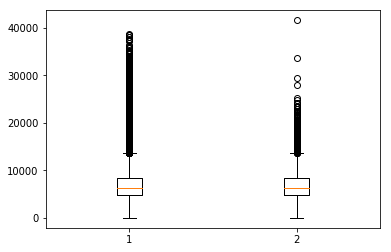

In [14]:
plt.boxplot([Y_train,Y_valid])
plt.show()

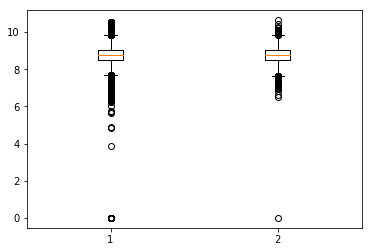

In [15]:
Y_train = np.log1p(Y_train)
Y_valid = np.log1p(Y_valid)
plt.boxplot([Y_train,Y_valid])
plt.show()

In [16]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [17]:
params = {"objective": "reg:linear",
          "eta": 0.1,
          "max_depth": 5,
          "min_child_weight":1,
          "gamma" :0,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 300

dtrain = xgb.DMatrix(X_train, Y_train)
dvalid = xgb.DMatrix(X_valid, Y_valid)
dtest = xgb.DMatrix(test)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
ret = {}
import time
start = time.time()
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50,evals_result =ret, feval=rmspe_xg, verbose_eval=True)
end = time.time()
print("Train use time:",end-start)

D:\AnaconDA\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	eval-rmse:7.43899	train-rmse:7.44362	eval-rmspe:0.999473	train-rmspe:0.999493
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:6.69695	train-rmse:6.70123	eval-rmspe:0.998761	train-rmspe:0.998784
[2]	eval-rmse:6.02928	train-rmse:6.03326	eval-rmspe:0.997475	train-rmspe:0.997503
[3]	eval-rmse:5.42862	train-rmse:5.43231	eval-rmspe:0.995307	train-rmspe:0.995342
[4]	eval-rmse:4.88827	train-rmse:4.89177	eval-rmspe:0.991863	train-rmspe:0.991908
[5]	eval-rmse:4.40244	train-rmse:4.40569	eval-rmspe:0.986706	train-rmspe:0.986766
[6]	eval-rmse:3.96533	train-rmse:3.96831	eval-rmspe:0.979376	train-rmspe:0.979453
[7]	eval-rmse:3.57223	train-rmse:3.57495	eval-rmspe:0.969419	train-rmspe:0.969518
[8]	eval-rmse:3.21907	train-rmse:3.2215	eval-rmspe:0.956422	train-rmspe:0.95655
[9]	eval-rmse:2.90137	train-rmse:2.90353	eval-rmspe:0.940144	train-rmspe:0.940302
[10]	eval-rmse:2.61571	train-rmse:2

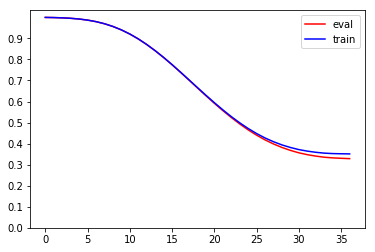

In [20]:
evaldata = ret['eval']['rmspe'][0:37]
traindata = ret['train']['rmspe'][0:37]
plt.plot(range(0,37,1),evaldata,color='red',label="eval")
plt.plot(range(0,37,1),traindata,color='blue',label="train")
plt.legend(loc='best')
y_tick = np.arange(0,1,0.1)
plt.yticks(y_tick)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=5,learning_rate =0.1, n_estimators=36,min_child_weight=1, gamma=0,verbose = 10,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test1,scoring ='neg_mean_squared_error',cv=5)
gsearch1.fit(X_train, Y_train)

D:\AnaconDA\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\AnaconDA\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\AnaconDA\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\AnaconDA\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\AnaconDA\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\AnaconDA\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is depr

In [ ]:
#从最终的训练importnace中看果然是时间序列影响比较大
xgb.plot_importance(gbm)

In [ ]:
#预测测试数据
regetTest = pd.read_csv("./test.csv")
replaceID = regetTest[regetTest.Open == 0.0]['Id']
print(replaceID.values)
test_probs = gbm.predict(dtest)
result = pd.DataFrame({"Id": TESTID , 'Sales': np.exp(test_probs)})
result.loc[result['Id'].isin(replaceID.values),'Sales'] = 0

In [ ]:
#预测测试数据输出
result.to_csv("xgboost_submission.csv", index=False)